In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import itertools
import time
from datetime import datetime

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [63]:
# Reading files 
df = pd.read_csv("Hotel Reservations.csv")

### Data quality check
*By Hoda Fakhari & Luna Nguyen*

In [56]:
# Total number of observations
df.shape

(36275, 21)

In [8]:
# Identifying number of missing values
print('There are', df.isnull().sum().sum(), 'missing values in the hotel reservation dataset.')

There are 0 missing values in the hotel reservation dataset.


In [10]:
# Identifying variable types to select categorical variables
df.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

The code below visualizes the distribution of all the continuous variables in the dataset.

In [6]:
#...Distribution of continuous variables...#
df.drop(['required_car_parking_space', 'repeated_guest', 'arrival_month', 'arrival_year'], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
no_of_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
no_of_weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
no_of_week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
arrival_date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0,31.0
no_of_previous_cancellations,36275.0,0.023349,0.368331,0.0,0.0,0.00,0.0,13.0
no_of_previous_bookings_not_canceled,36275.0,0.153411,1.754171,0.0,0.0,0.00,0.0,58.0
avg_price_per_room,36275.0,103.423539,35.089424,0.0,80.3,99.45,120.0,540.0
no_of_special_requests,36275.0,0.619655,0.786236,0.0,0.0,0.00,1.0,5.0


In [55]:
#...Distribution of categorical variables...#
for column in df[['required_car_parking_space', 'repeated_guest', 'arrival_month', 'arrival_year', 'type_of_meal_plan', 'room_type_reserved', 'market_segment_type']].columns:
    display(pd.crosstab(index=df[column], columns='% observations', normalize='columns')*100)


col_0,% observations
required_car_parking_space,
0,96.901447
1,3.098553


col_0,% observations
repeated_guest,
0,97.436251
1,2.563749


col_0,% observations
arrival_month,
1,2.795314
2,4.697450
3,6.500345
4,7.542385
5,7.161957
6,8.829773
7,8.049621
8,10.511371
9,12.711234


col_0,% observations
arrival_year,
2017,17.957271
2018,82.042729


col_0,% observations
type_of_meal_plan,
Meal Plan 1,76.733287
Meal Plan 2,9.110958
Meal Plan 3,0.013784
Not Selected,14.141971


col_0,% observations
room_type_reserved,
Room_Type 1,77.546520
Room_Type 2,1.907650
Room_Type 3,0.019297
Room_Type 4,16.697450
Room_Type 5,0.730531
Room_Type 6,2.662991
Room_Type 7,0.435562


col_0,% observations
market_segment_type,
Aviation,0.344590
Complementary,1.077877
Corporate,5.560303
Offline,29.022743
Online,63.994487


The code below assesses the distribution of the the response. 

In [38]:
# Proportion of 0 and 1s in response
df.booking_status.value_counts(1)

0    0.672364
1    0.327636
Name: booking_status, dtype: float64

<AxesSubplot:xlabel='booking_status', ylabel='count'>

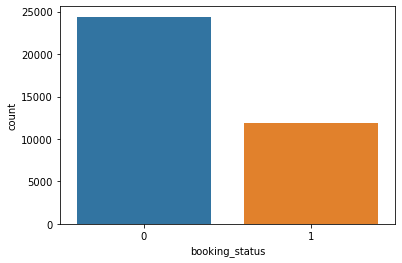

In [19]:
# Visualizing proportion of 0s and 1s in response
sns.countplot(x = 'booking_status', data = df);

### Data cleaning
*By *

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [ ]:
#...Code with comments...#

### Data preparation
*By Hoda Fakhari & *

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We converted categorical predictors to dummy variables for Variable Selection and Lasso / Ridge regression models.

2. We derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict booking status. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [64]:
######---------------Preparing Categorical Predictors----------------#########

# Convert categorical variables to dummies and append to df 
dummy_market = pd.get_dummies(df.market_segment_type)
dummy_month = pd.get_dummies(df.arrival_month)
dummy_meal = pd.get_dummies(df.type_of_meal_plan)
dummy_room = pd.get_dummies(df.room_type_reserved)

# Add dummy variables to df and drop 1 to avoid perfect multicollinearity in model 
df_dummy = pd.concat([df, dummy_market.drop('Aviation', axis = 1), dummy_month.drop(4, axis = 1), dummy_meal.drop('Meal Plan 3', axis = 1), dummy_room.drop('Room_Type 7', axis = 1)], axis = 1)
df_dummy.columns = df_dummy.columns.astype(str)

# Remove spaces from column names 
df_dummy.columns = df_dummy.columns.str.replace(' ', '')

# Convert month number to name in columns 
df_dummy.rename(columns={'1': 'January', '2': 'February', '3': 'March', 
                         '5': 'May', '6': 'June', '7': 'July', 
                        '8': 'August', '9': 'September', '10': 'October',
                        '11': 'November', '12': 'December'}, inplace=True)

# Mapping response to 0 (Not Canceled) and 1 (Canceled)
df_dummy['booking_status'] = df_dummy['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0})

In [3]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [65]:
######-----------Shuffling the dataset for K-fold------------#########

# Split train and test data 
train, test = train_test_split(df_dummy, test_size=0.25, random_state=25, shuffle=True)

In [ ]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Relationship between Predictors and Response
*By Hoda Fakhari*

The code below determines the correlation of continuous variables with each other and the response and visualizes the association of continuous and categorical variables with the response. 

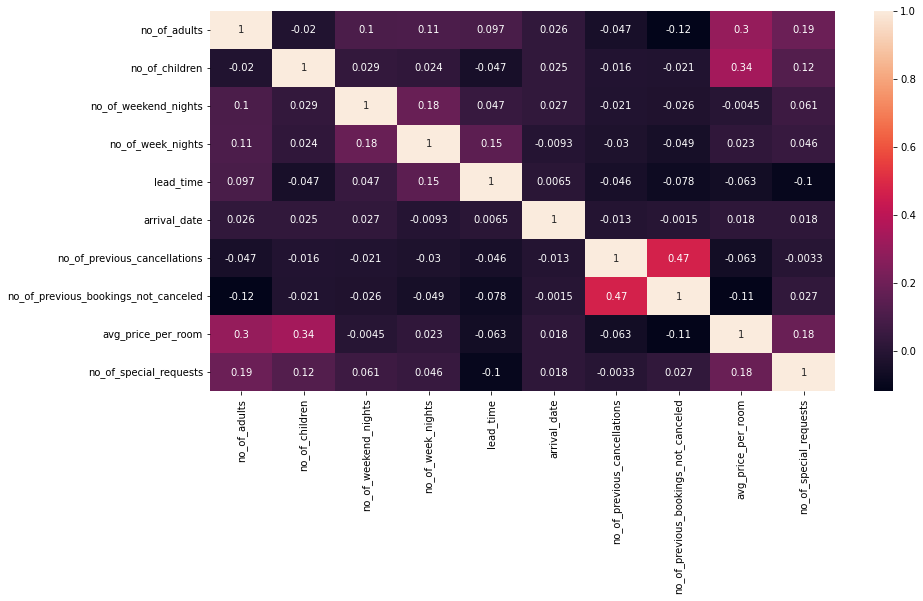

In [11]:
# Determining correlations between continuous predictors
plt.figure(figsize = (14,7));
sns.heatmap(df.drop(['required_car_parking_space', 'repeated_guest', 'arrival_month', 'arrival_year'], axis = 1).corr(), annot = True);

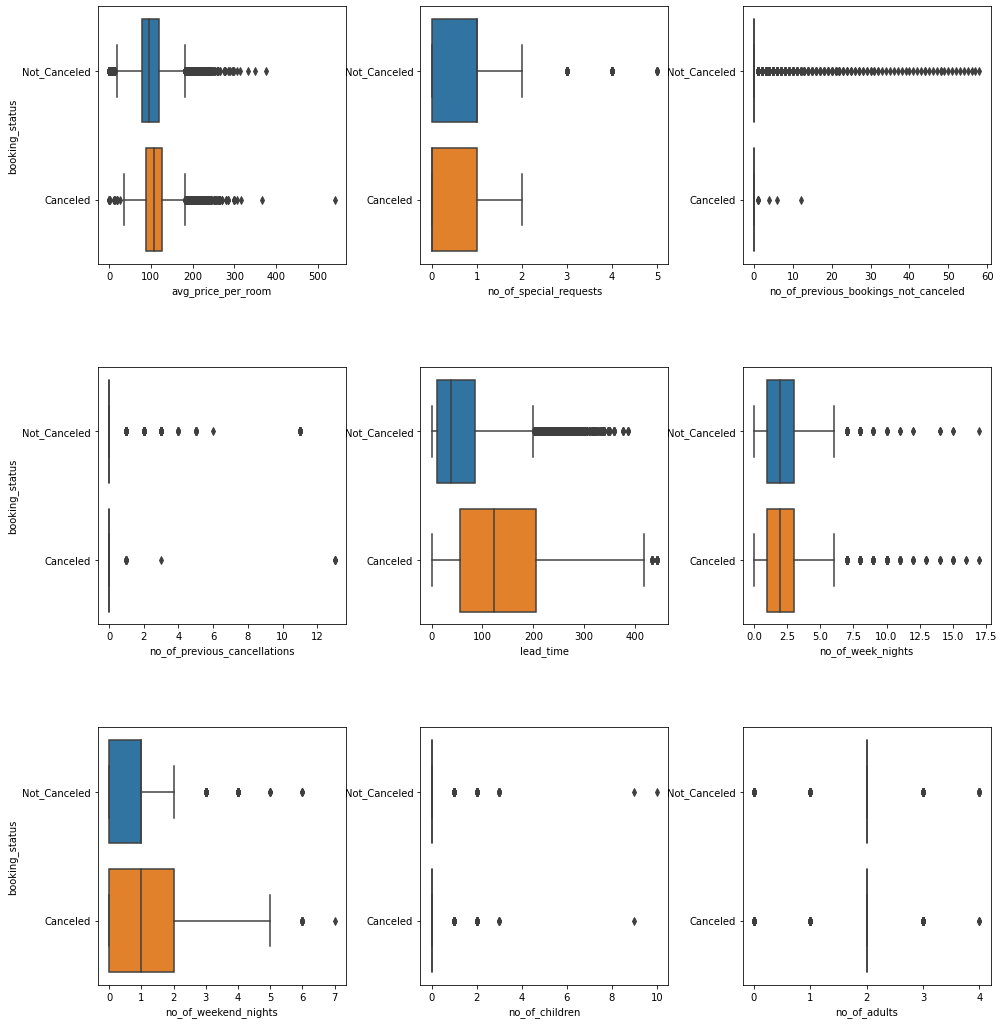

In [12]:
# Relationship between continuous variables and response
fig, ax = plt.subplots(3, 3, figsize=(16, 18));
plt.subplots_adjust(hspace = 0.4, wspace = 0.3);

sns.boxplot(data=df, x ='avg_price_per_room', y ='booking_status', ax=ax[0, 0]);
sns.boxplot(data=df, x ='no_of_special_requests', y ='booking_status', ax=ax[0, 1]).set(ylabel=None);
sns.boxplot(data=df, x ='no_of_previous_bookings_not_canceled', y ='booking_status', ax=ax[0, 2]).set(ylabel=None);
sns.boxplot(data=df, x ='no_of_previous_cancellations', y ='booking_status', ax=ax[1, 0]);
sns.boxplot(data=df, x ='lead_time', y ='booking_status', ax=ax[1, 1]).set(ylabel=None);
sns.boxplot(data=df, x ='no_of_week_nights', y ='booking_status', ax=ax[1, 2]).set(ylabel=None);
sns.boxplot(data=df, x ='no_of_weekend_nights', y ='booking_status', ax=ax[2, 0]);
sns.boxplot(data=df, x ='no_of_children', y ='booking_status', ax=ax[2, 1]).set(ylabel=None);
sns.boxplot(data=df, x ='no_of_adults', y ='booking_status', ax=ax[2, 2]).set(ylabel=None);

In [ ]:
# Mapping response to 0 (Not Canceled) and 1 (Canceled)
df['booking_status'].replace(['Canceled', 'Not_Canceled'],[1, 0], inplace=True)

In [57]:
# Correlation of continuous variables with response
df.drop(['required_car_parking_space', 'repeated_guest', 'arrival_month', 'arrival_year'], axis = 1).corrwith(df.booking_status)

no_of_adults                            0.086920
no_of_children                          0.033078
no_of_weekend_nights                    0.061563
no_of_week_nights                       0.092996
lead_time                               0.438538
arrival_date                            0.010629
no_of_previous_cancellations           -0.033728
no_of_previous_bookings_not_canceled   -0.060179
avg_price_per_room                      0.142569
no_of_special_requests                 -0.253070
booking_status                          1.000000
dtype: float64

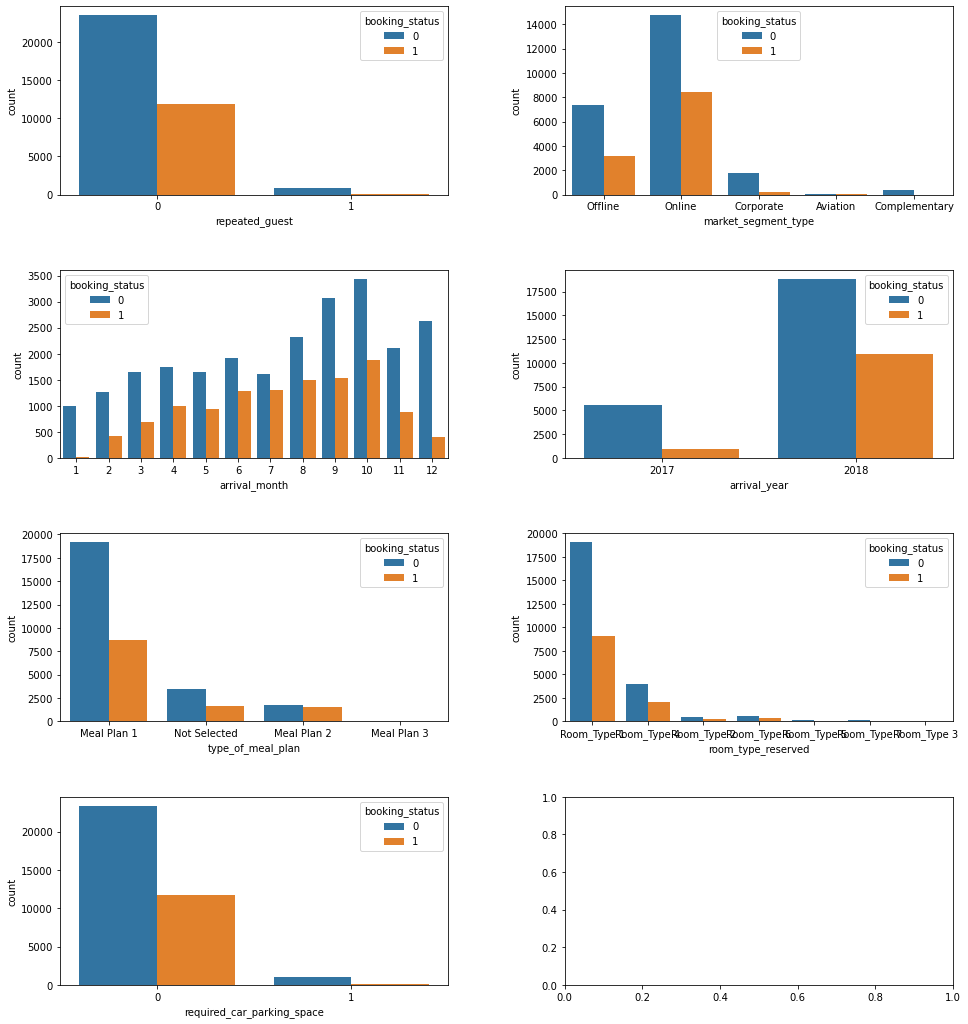

In [17]:
# Relationship between categorical variables and response
fig, ax = plt.subplots(4, 2, figsize=(16, 18));
plt.subplots_adjust(hspace = 0.4, wspace = 0.3);

sns.countplot(data=df, x ='repeated_guest', hue="booking_status", ax=ax[0, 0]);
sns.countplot(data=df, x='market_segment_type',hue='booking_status', ax=ax[0, 1]);
sns.countplot(data=df, x="arrival_month", hue="booking_status", ax=ax[1,0]);
sns.countplot(data=df, x="arrival_year",   hue="booking_status", ax=ax[1,1]);
sns.countplot(data=df, x="type_of_meal_plan",   hue="booking_status", ax=ax[2,0]);
sns.countplot(data=df, x="room_type_reserved",   hue="booking_status", ax=ax[2,1]);
sns.countplot(data=df, x="required_car_parking_space",   hue="booking_status", ax=ax[3,0]);

### Binning of Continuous Variables
*By Hoda Fakhari* 

Highly correlated continuous/numeric variables were binned and plotted to assess the use of transformations in the models.

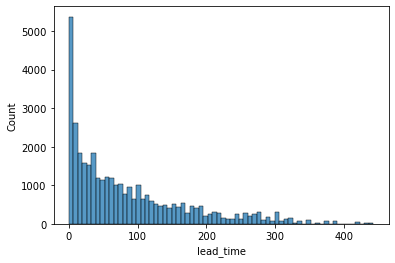

In [44]:
# Lead time distribution
sns.histplot(df.lead_time);

Text(0.5, 0, 'Lead Time Binned')

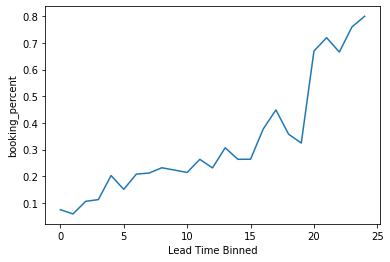

In [34]:
# Lead time
binned_lead = pd.qcut(df['lead_time'],25,retbins=True)
df['lead_binned'] = binned_lead[0]

lead_data = df.groupby('lead_binned')['booking_status'].agg([('booking_percent','mean'),('nobs','count')]).reset_index(drop=False);
sns.lineplot(x = lead_data.index, y= lead_data['booking_percent']);
plt.xlabel('Lead Time Binned');

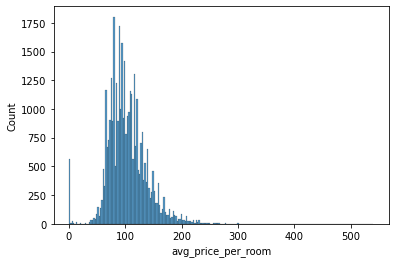

In [43]:
# Average Price per room distribution
sns.histplot(df.avg_price_per_room);

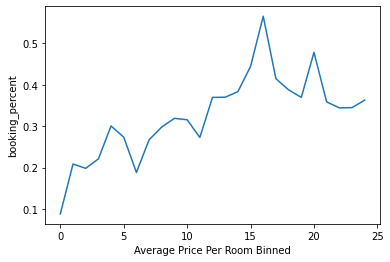

In [35]:
# Average Price per room
binned_price = pd.qcut(df['avg_price_per_room'],25,retbins=True)
df['price_binned'] = binned_price[0]

price_data = df.groupby('price_binned')['booking_status'].agg([('booking_percent','mean'),('nobs','count')]).reset_index(drop=False);
sns.lineplot(x = price_data.index, y= price_data['booking_percent']);
plt.xlabel('Average Price Per Room Binned');

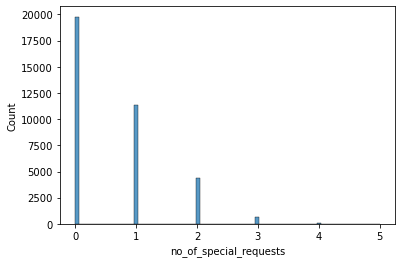

In [45]:
# Number of Special Requests Distribution
sns.histplot(df.no_of_special_requests);

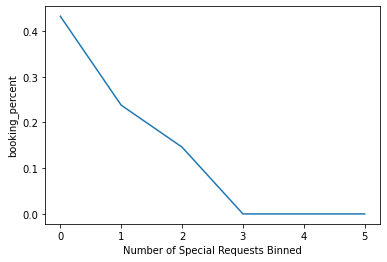

In [36]:
# Number of Special Requests
special_data = df.groupby('no_of_special_requests')['booking_status'].agg([('booking_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = special_data.index, y= special_data['booking_percent']);
plt.xlabel('Number of Special Requests Binned');

### Autocorrelation 
*By Luna Nguyen*

In [30]:
# Checking for the number of reservations cancelled and not cancelled every month
monthly_cancel = df.groupby(df.arrival_month).booking_status.value_counts()

# Creating a dataframe with the number of reservations cancelled and not cancelled for every month
monthly_cancel = pd.DataFrame({'Did not cancel': [990, 1274, 1658, 1741, 1650, 1912, 1606, 2325, 3073, 3437, 2105, 2619],
                   'Cancelled': [24, 430, 700, 995, 948, 1291, 1314, 1488, 1538, 1880, 875, 402]}, 
                  index=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

In [31]:
# Create a dataframe wiht the percentage of reservations cancelled and not cancelled for every month
monthly_cancel_percent = monthly_cancel.copy()
monthly_cancel_percent['Total'] = monthly_cancel_percent['Did not cancel'] + monthly_cancel_percent['Cancelled']
monthly_cancel_percent['Did not cancel percent'] = monthly_cancel_percent['Did not cancel']/monthly_cancel_percent['Total']
monthly_cancel_percent['Cancel percent'] = monthly_cancel_percent['Cancelled']/monthly_cancel_percent['Total']
monthly_cancel_percent = monthly_cancel_percent.drop(['Did not cancel', 'Cancelled', 'Total'], axis = 1)

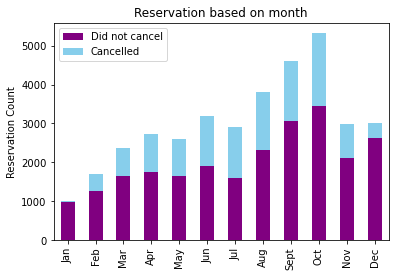

In [32]:
# Count of cancellations by month
monthly_cancel.plot(kind='bar', stacked=True, color=['purple', 'skyblue'])
plt.ylabel("Reservation Count")
plt.title("Reservation based on month")
plt.show()

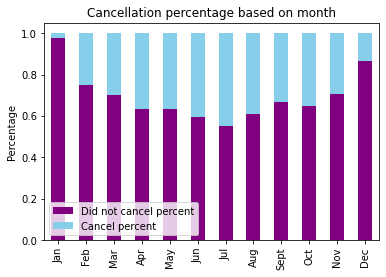

In [33]:
# Proportion of cancellations by month
monthly_cancel_percent.plot(kind='bar', stacked=True, color=['purple', 'skyblue'])
plt.ylabel("Percentage")
plt.title('Cancellation percentage based on month')
plt.show()

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

In [61]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

### Model 1) Baseline Model 
*By Kiara?*

In [66]:
# Model 1) Baseline Model
logit_model = sm.logit(formula = 'booking_status ~ no_of_adults + no_of_children  + no_of_weekend_nights + no_of_week_nights + type_of_meal_plan + required_car_parking_space + room_type_reserved +lead_time  + market_segment_type +repeated_guest + no_of_previous_cancellations + avg_price_per_room  + no_of_special_requests', data = train).fit()
logit_model.summary()

         Current function value: 0.422758
         Iterations: 35


C:\Users\hodaf\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27182
Method:                           MLE   Df Model:                           23
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.3301
Time:                        13:47:10   Log-Likelihood:                -11502.
converged:                      False   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -3.0608      0.247    -12.408      0.000      -3.544      -2.577
type_of_meal_plan[T.Meal Plan 2]         0.0878      0.062      1.424      0.154      -0.033       0.209
type_of_meal_plan[T.Meal Plan 3]         3.4190   6.34e+04   5.39e-05      1.000   -1.24e+05    1.24e+05
type_of_meal_plan[T.Not Selected]        0.2763      0.051      5.440      0.000       0.177       0.376
room_type_reserved[T.Room_Type 2]       -0.3331      0.128     -2.602      0.009      -0.584      -0.082
room_type_reserved[T.Room_Type 3]        0.6164      1.596      0.386      0.699      -2.512       3.745
room_type_reserved[T.Room_Type 4]       -0.2370      0.052     -4.593      0.000      -0.338      -0.136
room_type_reserved[T.Room_Type 5]       -0.8168      0.201     -4.069      0.000      -1.210      -0.423
room_type_reserved[T.Room_Type 6]       -1.0549      0.146     -7.218      0.000      -1.341      -0.768
room_type_reserved[T.Room_Type 7]       -1.3978      0.296     -4.721      0.000      -1.978      -0.817
market_segment_type[T.Complementary]   -21.7108   6679.484     -0.003      0.997   -1.31e+04    1.31e+04
market_segment_type[T.Corporate]        -1.0148      0.251     -4.035      0.000      -1.508      -0.522
market_segment_type[T.Offline]          -2.0496      0.241     -8.508      0.000      -2.522      -1.577
market_segment_type[T.Online]           -0.1827      0.238     -0.768      0.442      -0.649       0.283
no_of_adults                             0.0873      0.036      2.393      0.017       0.016       0.159
no_of_children                           0.1514      0.057      2.666      0.008       0.040       0.263
no_of_weekend_nights                     0.1278      0.019      6.671      0.000       0.090       0.165
no_of_week_nights                        0.0417      0.012      3.521      0.000       0.018       0.065
required_car_parking_space              -1.7151      0.141    -12.185      0.000      -1.991      -1.439
lead_time                                0.0159      0.000     64.764      0.000       0.015       0.016
repeated_guest                          -2.3456      0.446     -5.257      0.000      -3.220      -1.471
no_of_previous_cancellations             0.2366      0.066      3.599      0.000       0.108       0.365
avg_price_per_room                       0.0197      0.001     28.802      0.000       0.018       0.021
no_of_special_requests                  -1.5371      0.029    -52.521      0.000      -1.594      -1.480
========================================================================================================
"""

Classification accuracy = 79.6%
Precision = 67.7%
TPR or Recall = 71.4%
FNR = 28.6%
FPR = 16.4%
ROC-AUC = 86.4%


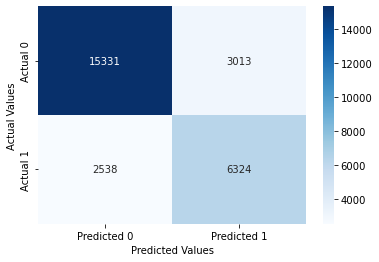

In [67]:
# Evaluating Model 1 on train data
confusion_matrix_data(train, train.booking_status, logit_model, cutoff = 0.4)

Classification accuracy = 78.7%
Precision = 67.7%
TPR or Recall = 68.9%
FNR = 31.1%
FPR = 16.5%
ROC-AUC = 85.4%


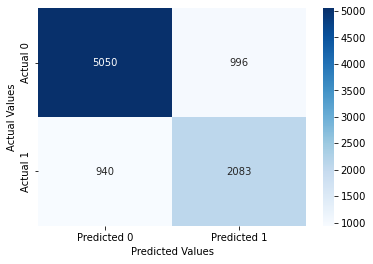

In [68]:
# Evaluating Model 1 on test data
confusion_matrix_data(test, test.booking_status, logit_model, cutoff = 0.4)

In [69]:
#Predict the values using the Model 1 (Baseline)
pred_values_1 = logit_model.predict(test)

### Model 2) EDA-Based
*By Hoda Fakhari*

In [70]:
# Model 2) EDA-Based Logit Model - By Hoda Fakhari
eda_model = sm.logit('booking_status ~ np.log(lead_time+1) + np.log(avg_price_per_room+1) + no_of_special_requests', data = train).fit()
eda_model.summary()

Optimization terminated successfully.
         Current function value: 0.478240
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27202
Method:                           MLE   Df Model:                            3
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.2422
Time:                        13:48:34   Log-Likelihood:                -13011.
converged:                       True   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -13.4977      0.288    -46.883      0.000     -14.062     -12.933
np.log(lead_time + 1)              0.8436      0.015     57.079      0.000       0.815       0.873
np.log(avg_price_per_room + 1)     2.1477      0.058     37.061      0.000       2.034       2.261
no_of_special_requests            -1.0933      0.024    -45.054      0.000      -1.141      -1.046
==================================================================================================
"""

Classification accuracy = 75.6%
Precision = 60.9%
TPR or Recall = 70.5%
FNR = 29.5%
FPR = 21.9%
ROC-AUC = 82.2%


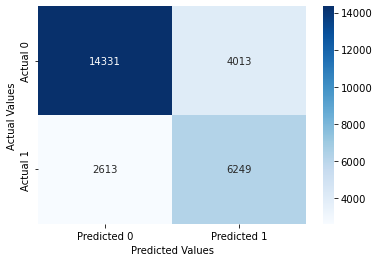

In [71]:
# Evaluating Model 2 on train data
confusion_matrix_data(train, train.booking_status, eda_model, cutoff = 0.4)

Classification accuracy = 74.9%
Precision = 60.9%
TPR or Recall = 68.7%
FNR = 31.3%
FPR = 22.0%
ROC-AUC = 81.1%


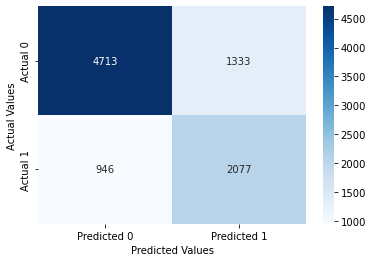

In [72]:
# Evaluating Model 2 on test data
confusion_matrix_data(test, test.booking_status, eda_model, cutoff = 0.4)

In [73]:
#Predict the values using the EDA-Based Logit model
pred_values_2 = eda_model.predict(test)

### Model 3) Variable Selection
*By Hoda Fakhari*

Optimization terminated successfully.
         Current function value: 0.627206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613451
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.631083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622996
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.630324
 

Optimization terminated successfully.
         Current function value: 0.471021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461682
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.462742
 

Optimization terminated successfully.
         Current function value: 0.450366
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.449956
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.446986
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.447981
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.447298
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.447974
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.446665
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.448016
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.447101
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.443283
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.443046
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.443139
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442714
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442682
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442544
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442722
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.442494
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442570
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

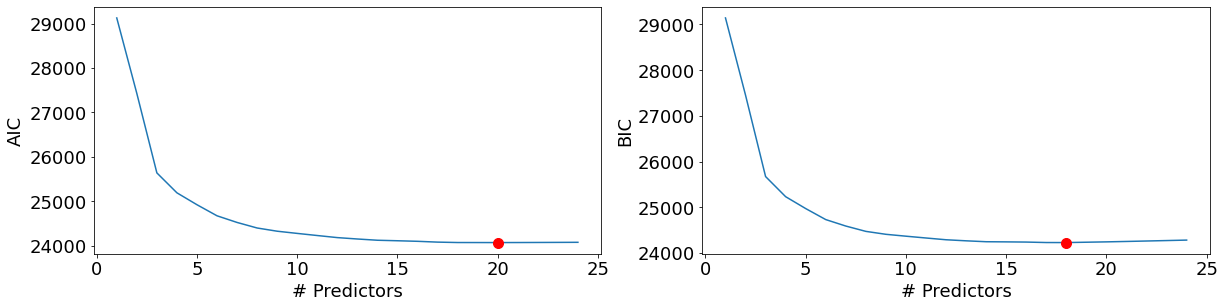

In [74]:
# Model 3) Forward/Backward Selection Model (Produced same model with 18 predictors based on BIC criterion)

# Continuous and categorical predictors (except market_segment_type, type_of_meal_plan, room_type_reserved)
X = train[['no_of_adults', 'no_of_children','no_of_weekend_nights','no_of_week_nights',
           'required_car_parking_space','lead_time','arrival_year','arrival_date','repeated_guest', 
           'no_of_previous_cancellations','no_of_previous_bookings_not_canceled','avg_price_per_room', 
           'no_of_special_requests', 'January','February', 'March', 'May', 'June', 'July', 
           'August', 'September','October', 'November', 'December']]

#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate BIC
    model = sm.logit('booking_status~' + '+'.join(predictor_subset), data = train).fit()
    BIC = model.bic
    return {"model":model, "BIC":BIC}

#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest BIC
    best_model = models.loc[models['BIC'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["BIC", "model"])

    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    return models_best

models_best = forward_selection()

In [ ]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)


    # AIC and BIC 
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 1)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

best_sub_plots()

In [75]:
best_forward_model = models_best.loc[18,'model']
best_forward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27187
Method:                           MLE   Df Model:                           18
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.3002
Time:                        13:53:18   Log-Likelihood:                -12016.
converged:                       True   LL-Null:                       -17170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -1871.9280    108.161    -17.307      0.000   -2083.920   -1659.936
lead_time                        0.0128      0.000     55.754      0.000       0.012       0.013
no_of_special_requests          -1.1974      0.027    -45.056      0.000      -1.250      -1.145
avg_price_per_room               0.0189      0.001     32.373      0.000       0.018       0.020
arrival_year                     0.9258      0.054     17.269      0.000       0.821       1.031
December                        -1.3421      0.081    -16.521      0.000      -1.501      -1.183
January                         -2.5764      0.246    -10.456      0.000      -3.059      -2.093
required_car_parking_space      -1.4755      0.138    -10.702      0.000      -1.746      -1.205
no_of_weekend_nights             0.1627      0.019      8.745      0.000       0.126       0.199
repeated_guest                  -2.4011      0.409     -5.877      0.000      -3.202      -1.600
June                            -0.3645      0.056     -6.483      0.000      -0.475      -0.254
September                       -0.3325      0.054     -6.176      0.000      -0.438      -0.227
May                             -0.3013      0.061     -4.931      0.000      -0.421      -0.182
no_of_week_nights                0.0619      0.012      5.308      0.000       0.039       0.085
no_of_adults                     0.1847      0.033      5.513      0.000       0.119       0.250
February                         0.3980      0.079      5.027      0.000       0.243       0.553
November                         0.3019      0.066      4.607      0.000       0.173       0.430
March                            0.2974      0.065      4.563      0.000       0.170       0.425
no_of_previous_cancellations     0.2785      0.090      3.101      0.002       0.102       0.454
================================================================================================
"""

In [76]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['BIC'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward_selection():
    models_best = pd.DataFrame(columns=["BIC", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = backward_selection()

Optimization terminated successfully.
         Current function value: 0.441520
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.445820
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.441725
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.441543
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.441987
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.441521
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.441529
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.442069
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.441878
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.445677
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.489076
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.462522
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.441583
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.441768
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.442131
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.441584
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.446979
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.516013
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.445922
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.489688
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.462855
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442900
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.447733
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.517009
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.444546
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442369
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.443266
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.4

Optimization terminated successfully.
         Current function value: 0.527740
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.446605
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.445766
         Iterations 11
Processed  12 models on 11 predictors in 2.2211074829101562 seconds.
Optimization terminated successfully.
         Current function value: 0.450991
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.445720
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.445990
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.449610
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.491627
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.467958
         Iterations 12
Opti

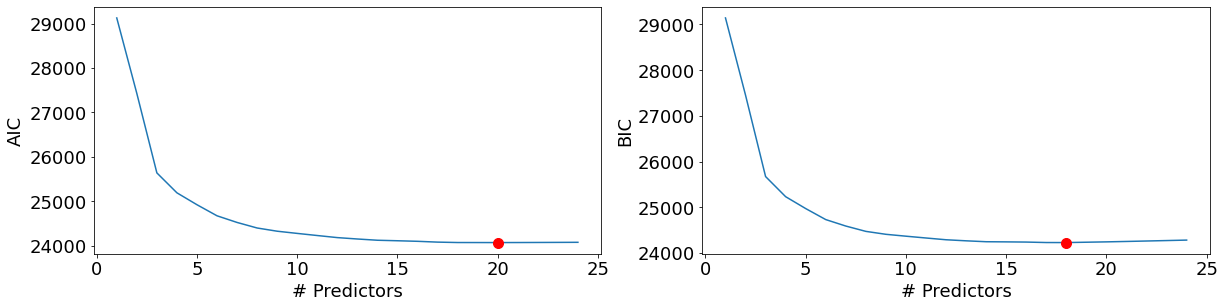

In [77]:
best_sub_plots()

Classification accuracy = 78.5%
Precision = 66.4%
TPR or Recall = 68.7%
FNR = 31.3%
FPR = 16.8%
ROC-AUC = 84.8%


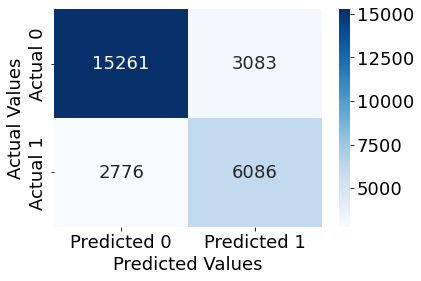

In [78]:
# Evaluating Model 3 on train data
confusion_matrix_data(train, train.booking_status, best_forward_model, cutoff = 0.4)

Classification accuracy = 77.3%
Precision = 66.1%
TPR or Recall = 65.2%
FNR = 34.8%
FPR = 16.7%
ROC-AUC = 83.7%


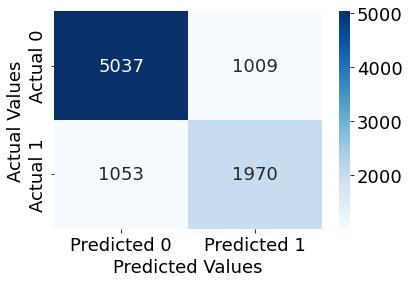

In [79]:
# Evaluating Model 3 on test data
confusion_matrix_data(test, test.booking_status, best_forward_model, cutoff = 0.4)

In [80]:
#Predict the values using the best Forward/Backward model
pred_values_3 = best_forward_model.predict(test)

### Model 4) KNN
*By Hoda Fakhari*

In [82]:
# Model 4) KNN

# Split train and test datasets
y = df_dummy.booking_status
X = df_dummy.drop(['booking_status', 'Booking_ID', 'type_of_meal_plan', 'market_segment_type', 'arrival_month', 'room_type_reserved'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)

# KNN with all predictors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train, y_train)

Classification accuracy = 86.8%
Precision = 84.5%
TPR or Recall = 72.8%
FNR = 27.2%
FPR = 6.5%
ROC-AUC = 83.2%


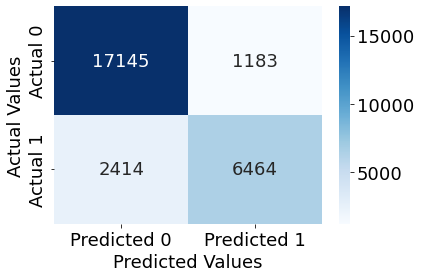

In [83]:
# Evaluating Model 4 on train data
confusion_matrix_data(X_train, y_train, knn, cutoff = 0.4)

Classification accuracy = 79.6%
Precision = 73.6%
TPR or Recall = 59.9%
FNR = 40.1%
FPR = 10.7%
ROC-AUC = 74.6%


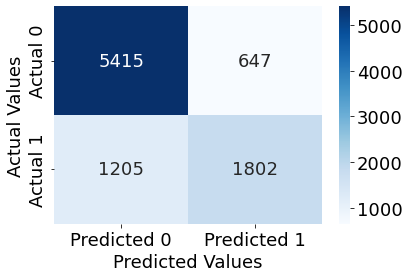

In [84]:
# Evaluating Model 4 on test data
confusion_matrix_data(X_test, y_test, knn, cutoff = 0.4)

In [85]:
#Predict the values using the Model 4 (KNN)
pred_values_4 = knn.predict(X_test)

### Model 5) KNN + Variable Selection
*By Hoda Fakhari*

In [101]:
# Model 5) KNN + Variable Selection 

# KNN with 18 features selected from forward/backward selection 
y = df_dummy.booking_status
X = df_dummy[['no_of_adults', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space',
            'lead_time', 'arrival_year', 'repeated_guest', 'no_of_previous_cancellations', 
            'avg_price_per_room', 'no_of_special_requests', 'December', 'January',
             'June', 'September', 'May', 'February', 'November', 'March']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)
knn_var = KNeighborsClassifier().fit(X_train, y_train)

Classification accuracy = 87.1%
Precision = 84.7%
TPR or Recall = 73.8%
FNR = 26.2%
FPR = 6.4%
ROC-AUC = 83.7%


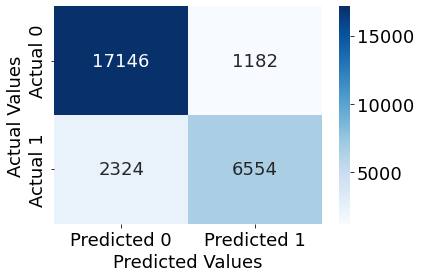

In [103]:
# Evaluating Model 5 on train data
confusion_matrix_data(X_train, y_train, knn_var, cutoff = 0.4)

Classification accuracy = 81.0%
Precision = 75.7%
TPR or Recall = 62.9%
FNR = 37.1%
FPR = 10.0%
ROC-AUC = 76.5%


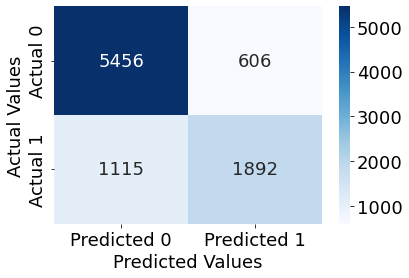

In [112]:
# Evaluating Model 5 on test data
confusion_matrix_data(X_test, y_test, knn_var, cutoff = 0.4)

In [102]:
#Predict the values using the KNN +variable selection model
pred_values_5 = knn_var.predict(X_test)

### Model 6) Ridge
*By Hoda Fakhari*

In [86]:
# Model 6) Ridge

y = train.booking_status

#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
X = train.loc[:,['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space','lead_time', 'arrival_year', 
       'arrival_date', 'repeated_guest','no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'Complementary', 'Corporate', 
        'Offline', 'Online', 'January','February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2','NotSelected', 
        'Room_Type1', 'Room_Type2', 'Room_Type3', 'Room_Type4','Room_Type5', 'Room_Type6']]

#Defining a scaler object
scaler = StandardScaler()

scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

#Filtering all predictors in test dataset
Xtest = test.loc[:,['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space',
       'lead_time', 'arrival_year', 'arrival_date', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 
       'Complementary', 'Corporate', 'Offline', 'Online', 'January',
       'February', 'March', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'MealPlan1', 'MealPlan2',
       'NotSelected', 'Room_Type1', 'Room_Type2', 'Room_Type3', 'Room_Type4',
       'Room_Type5', 'Room_Type6']]

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns.drop(['booking_status', 'Booking_ID', 'type_of_meal_plan', 'market_segment_type', 
                               'arrival_month', 'room_type_reserved']), loc='center left', bbox_to_anchor=(1, 0.5));

15.811388300841896

In [99]:
alphas = 10**np.linspace(10,-2,200)*0.5

#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)

In [ ]:
#Cross validation to find the optimal value of the tuning parameter - lambda
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

In [87]:
#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge = ridge.fit(Xstd, y)

In [88]:
ridge_coeff = pd.DataFrame(ridge.coef_, columns = ['coefficients'])
ridge_coeff['predictors'] = X.columns
ridge_coeff

,coefficients,predictors
0,0.009002,no_of_adults
1,0.013773,no_of_children
2,0.014445,no_of_weekend_nights
3,0.011074,no_of_week_nights
4,-0.026611,required_car_parking_space
5,0.214746,lead_time
6,0.020401,arrival_year
7,0.003246,arrival_date
8,0.000193,repeated_guest
9,-0.000368,no_of_previous_cancellations


Classification accuracy = 76.7%
Precision = 65.1%
TPR or Recall = 74.4%
FNR = 25.6%
FPR = 22.0%
ROC-AUC = 87.2%


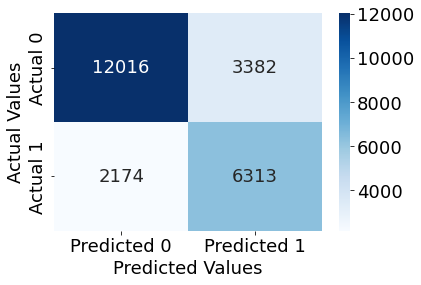

In [89]:
# Evaluating Model 6 on train data
confusion_matrix_data(Xstd, y, ridge, cutoff = 0.4)

Classification accuracy = 76.1%
Precision = 65.2%
TPR or Recall = 72.6%
FNR = 27.4%
FPR = 22.0%
ROC-AUC = 86.2%


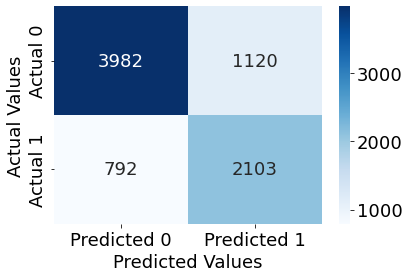

In [90]:
# Evaluating Model 6 on test data
confusion_matrix_data(Xtest_std, test.booking_status, ridge, cutoff = 0.4)

In [91]:
#Predict the values using the ridge model
pred_values_6 = ridge.predict(Xtest_std)

### Model 7) Lasso
*By Hoda Fakhari*

In [92]:
# Model 7) Lasso

0.00014665831391950227

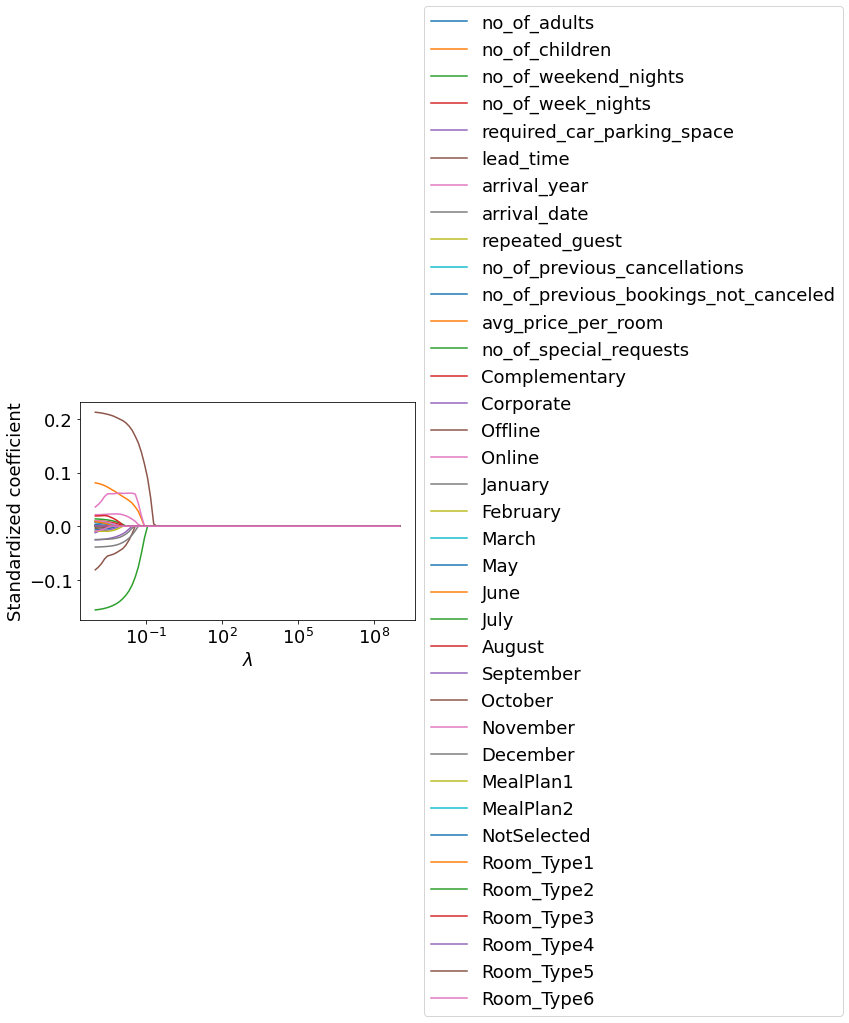

In [98]:
alphas = 10**np.linspace(10,-2,100)*0.1

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)
    
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns.drop(['booking_status', 'Booking_ID', 'type_of_meal_plan', 'market_segment_type', 
                               'arrival_month', 'room_type_reserved']), loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
#Cross validation to find the optimal value of the tuning parameter - lambda
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

In [93]:
#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso = lasso.fit(Xstd, y)

In [96]:
lasso_coeff = pd.DataFrame(lasso.coef_, columns = ['coefficients'])
lasso_coeff['predictors'] = X.columns
lasso_coeff

,coefficients,predictors
0,0.008796,no_of_adults
1,0.013093,no_of_children
2,0.014314,no_of_weekend_nights
3,0.010897,no_of_week_nights
4,-0.026475,required_car_parking_space
5,0.214581,lead_time
6,0.020514,arrival_year
7,0.003092,arrival_date
8,0.000000,repeated_guest
9,-0.000109,no_of_previous_cancellations


Classification accuracy = 76.7%
Precision = 65.1%
TPR or Recall = 74.2%
FNR = 25.8%
FPR = 21.9%
ROC-AUC = 87.2%


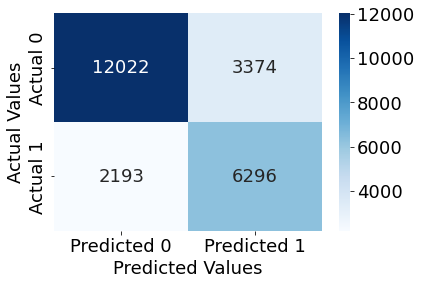

In [94]:
# Evaluating Model 7 on train data
confusion_matrix_data(Xstd, y, lasso, cutoff = 0.4)

Classification accuracy = 76.1%
Precision = 65.2%
TPR or Recall = 72.4%
FNR = 27.6%
FPR = 21.9%
ROC-AUC = 86.2%


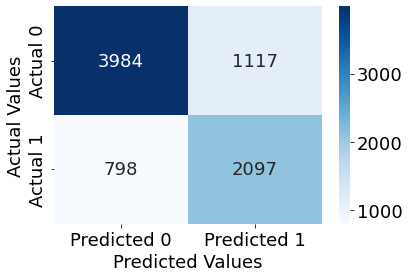

In [95]:
# Evaluating Model 7 on test data
confusion_matrix_data(Xtest_std, test.booking_status, lasso, cutoff = 0.4)

In [97]:
#Predict the values using the lasso model
pred_values_7 = lasso.predict(Xtest_std)

### Code fitting the final model
*By Elena Llaguno Cantu*

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [105]:
df = pd.DataFrame()
df['Model_1'] = pred_values_1
df['Model_2'] = pred_values_2
df['Model_3'] = pred_values_3
df['Model_4'] = pred_values_4
df['Model_5'] = pred_values_5
df['Model_6'] = pred_values_6
df['Model_7'] = pred_values_7

In [106]:
def applying_cutoff(df): 
    for col in df.columns:
        for index, value in df[col].iteritems():
            if value < 0.5:
                df.at[index, col] = 0
            else:
                df.at[index, col] = 1  
            
    return df

In [107]:
df = applying_cutoff(df)
df

,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7
28112,1.0,0.0,0.0,1,0,0.0,0.0
6482,0.0,0.0,0.0,1,1,0.0,0.0
12183,0.0,0.0,0.0,1,1,0.0,0.0
34739,0.0,0.0,0.0,0,0,0.0,0.0
2375,1.0,1.0,1.0,0,0,1.0,1.0
...,...,...,...,...,...,...,...
28804,0.0,0.0,0.0,0,0,0.0,0.0
9727,0.0,0.0,0.0,0,0,0.0,0.0
36076,1.0,1.0,1.0,0,1,1.0,1.0
25340,0.0,1.0,1.0,0,0,0.0,0.0


In [108]:
# averaging the model results function
def combining_results(df): 
    df['sum'] = df.sum(axis=1)

    for index, row in df.iterrows():
        if row['sum'] >= 3:
            df.at[index, 'sum'] = 1
        else:
            df.at[index, 'sum'] = 0
        
    pred_values = df['sum']
    
    return pred_values

In [109]:
final_values = combining_results(df)
final_values

28112    0.0
6482     0.0
12183    0.0
34739    0.0
2375     1.0
        ... 
28804    0.0
9727     0.0
36076    1.0
25340    0.0
34948    0.0
Name: sum, Length: 9069, dtype: float64

In [110]:
# Modified confusion matrix function

from sklearn.metrics import roc_curve, auc

def confusion_matrix_data_modified(pred_values,actual_values,cutoff=0.5):
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

Classification accuracy = 78.9%
Precision = 72.0%
TPR or Recall = 60.1%
FNR = 39.9%
FPR = 11.7%
ROC-AUC = 74.2%


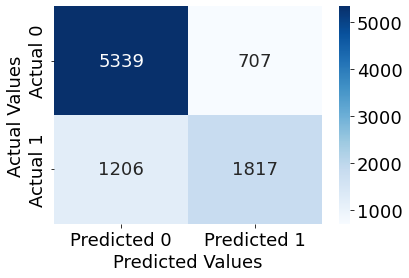

In [111]:
# Evaluating final model on test data
confusion_matrix_data_modified(final_values,test.booking_status,0.45)

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.